# Image Classification

ในตัวอย่างนี้จะเป็นการแสดงตัวอย่างของการใช้ Transformer ซึ่งเป็นรูปแบบหนึ่งของ deeplearning นอกเหนือจาก CNN ที่สามารถใช้ในการทำ Computer vision ได้เช่นกันโดยจะเป็นการทำนายชื่อของเมนูอาหารจากรูปภาพ

## Overview of Transformer

Transformers เป็นโมเดล deeplearning ที่ถูกคิดค้นขึ้นมาเพื่อใช้ในงาน Natural Language Processing เช่น แปลภาษา หรือ Large language model อย่าง Chat GPT.โดยในปัจจุบัน transformers ก็ได้ถูกนำมาประยุกต์ใช้ในส่วนของ computer vision เช่นกันโดยการทำงานของ Transformers จะแบ่งรูปภาพออกมาเป็นส่วนๆก่อนจะแปลงภาพย่อยเหล่านั้นออกมาเป็น vector ที่แสดงถึงคุณลักษณะและตำแหน่ง ของภาพนั้นๆ ต่อมาvectorจะถูกนำไปแปรผลด้วยโมเดลที่เรียกว่า encoder ซึ่งใน encoder นั้นจะมีส่วนประกอบที่เรียกว่า Attention ซึ่งจะช่วยให้โมเดลเรียนรู้ได้ว่าส่วนไหนของภาพที่ควรให้ความสำคัญ ก่อนจะเข้าสู่ Neural Network ในขั้นต่อๆเพื่อเรียนรู้ที่จะแยกแยะภาพจาก feature ที่ได้รับจนออกมาเป็น class ของภาพที่ใส่เข้าไป

อ่านเพิ่มเติม: [Vision Transformer](https://paperswithcode.com/method/vision-transformer)

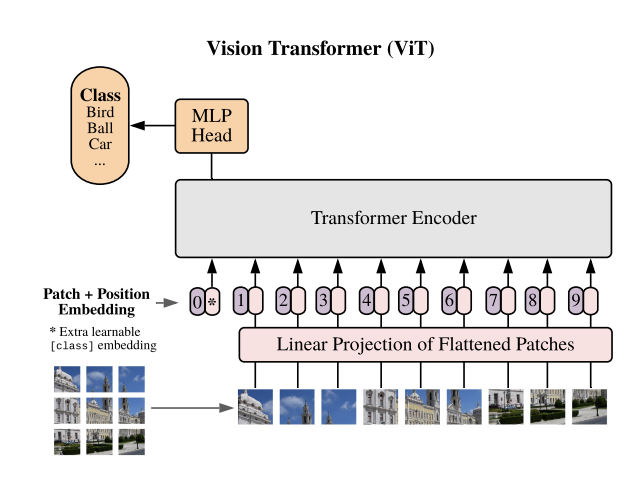

## Thai Food Classification with Huggingface's Transformers

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/04v_classification_transformers.ipynb)

ใน Notebook นี้เราจะโหลดชุดข้อมูลอาหารไทย 50 ชนิด สร้าง datasets และจะใช้วิธีการ fine-tune โมเดล Swin transformer tiny เพื่อแบ่งประเภทภาพอาหารไทย 50 ชนิด

อ่านเพิ่มเติม: [huggingface datasets](https://huggingface.co/docs/datasets/image_load)

In [1]:
!pip install datasets
!pip install git+https://github.com/huggingface/transformers
!pip install gradio
!pip install transformers[torch]

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-1nsnvxd0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-1nsnvxd0
  Resolved https://github.com/huggingface/transformers to commit cd4584e3c809bb9e1392ccd3fe38b40daba5519a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.6 MB/s eta 0:00:00


## Download Datasets

- ดาวน์โหลด FoodyDudy dataset จาก github
- จากนั้นใช้ `load_dataset("imagefolder", ...)` เพื่ออ่านข้อมูลมาใน class `Dataset`
- ทำการโหลด feature extractor ของโมเดลที่จะใช้ fine-tune เพื่อใช้ในการปรับขนาดของภาพ

In [2]:
!git clone https://github.com/GemmyTheGeek/FoodyDudy.git

fatal: destination path 'FoodyDudy' already exists and is not an empty directory.


list รายชื่ออาหารทั้งหมดออกมา และแสดง id

In [3]:
food_list = [
    'green_curry', 'tepo_curry', 'liang_curry', 'taohoo_moosup', 'mara_yadsai',
    'masaman', 'orange_curry', 'cashew_chicken', 'omelette', 'sunny_side_up',
    'palo_egg', 'sil_egg', 'nun_banana', 'kua_gai', 'cabbage_fish_sauce',
    'river_prawn', 'shrimp_ob_woonsen', 'kanom_krok', 'mango_sticky_rice', 'kao_kamoo',
    'kao_klook_kapi', 'kaosoi', 'kao_pad', 'kao_pad_shrimp', 'chicken_rice',
    'kao_mok_gai', 'tom_ka_gai', 'tom_yum_kung', 'tod_mun', 'poh_pia',
    'pak_boong_fai_daeng', 'padthai', 'pad_krapao', 'pad_si_ew', 'pad_fakthong',
    'eggplant_stirfry', 'pad_hoi_lai', 'foithong', 'panaeng', 'yum_tua_ploo',
    'yum_woonsen', 'larb_moo', 'pumpkin_custard', 'sakoo_sai_moo', 'somtam',
    'moopoing','satay', 'hor_mok'
]

# สร้าง dictionary
id2food = {str(i).zfill(2): f for i, f in enumerate(food_list)}

In [4]:
id2food

{'00': 'green_curry',
 '01': 'tepo_curry',
 '02': 'liang_curry',
 '03': 'taohoo_moosup',
 '04': 'mara_yadsai',
 '05': 'masaman',
 '06': 'orange_curry',
 '07': 'cashew_chicken',
 '08': 'omelette',
 '09': 'sunny_side_up',
 '10': 'palo_egg',
 '11': 'sil_egg',
 '12': 'nun_banana',
 '13': 'kua_gai',
 '14': 'cabbage_fish_sauce',
 '15': 'river_prawn',
 '16': 'shrimp_ob_woonsen',
 '17': 'kanom_krok',
 '18': 'mango_sticky_rice',
 '19': 'kao_kamoo',
 '20': 'kao_klook_kapi',
 '21': 'kaosoi',
 '22': 'kao_pad',
 '23': 'kao_pad_shrimp',
 '24': 'chicken_rice',
 '25': 'kao_mok_gai',
 '26': 'tom_ka_gai',
 '27': 'tom_yum_kung',
 '28': 'tod_mun',
 '29': 'poh_pia',
 '30': 'pak_boong_fai_daeng',
 '31': 'padthai',
 '32': 'pad_krapao',
 '33': 'pad_si_ew',
 '34': 'pad_fakthong',
 '35': 'eggplant_stirfry',
 '36': 'pad_hoi_lai',
 '37': 'foithong',
 '38': 'panaeng',
 '39': 'yum_tua_ploo',
 '40': 'yum_woonsen',
 '41': 'larb_moo',
 '42': 'pumpkin_custard',
 '43': 'sakoo_sai_moo',
 '44': 'somtam',
 '45': 'moopoing'

In [5]:
from datasets import load_dataset, load_metric

download dataset และ metric ที่ใช้ในการเทรนโมเดลโดยใช้ `load_dataset` และ `load_metric`

In [6]:
dataset = load_dataset("imagefolder", data_dir="FoodyDudy/images")
accuracy = load_metric("accuracy")

Resolving data files:   0%|          | 0/11520 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1440 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1440 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-6-87cdaa45b993>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")


dataset ของเราประกอบไปด้วย \

train 11520 ภาพ test & validation 1440 ภาพ

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 11520
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1440
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1440
    })
})

In [8]:
from transformers import AutoFeatureExtractor

# extracting feature โดยใช้ โมเดลที่ถูกเทรนมาก่อนแล้ว
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feat_size = tuple(feature_extractor.size.values())
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

จากนั้นสร้าง `preprocess_train` และ `preprocess_val` เพื่อ preprocess ข้อมูลภาพในแต่ละ batch ของเรา จะเห็นว่าภาพของเราอยู่ใน key ที่ชื่อว่า `image` และเมื่อเรา preprocess ภาพเรียบร้อยจะเก็บไว้ใน key ที่ชื่อว่า `pixel_values` และเพื่อไม่ให้ประสิทธิภาพของโมเดลถูกจำกัดจากเซ็ตภาพที่เราใช้ เราจึงทำการ transform รูปภาพให้มีคุณลักษณะหลากหลายยิ่งขึ้น เช่นในภาพตัวอย่างที่มีความต่างทั้งในแง่ของสี มุมมอง รวมถึง noise แต่ทุกภาพก็คือนกแก้วเหมือนกัน ซึ่งเราต้องการให้โมเดลไม่ถูก limit ด้วยปัจจัยเหล่านี้ (ศึกษาเพิ่มเติมที่ [Illustration of Transform](https://pytorch.org/vision/main/auto_examples/plot_transforms.html) )

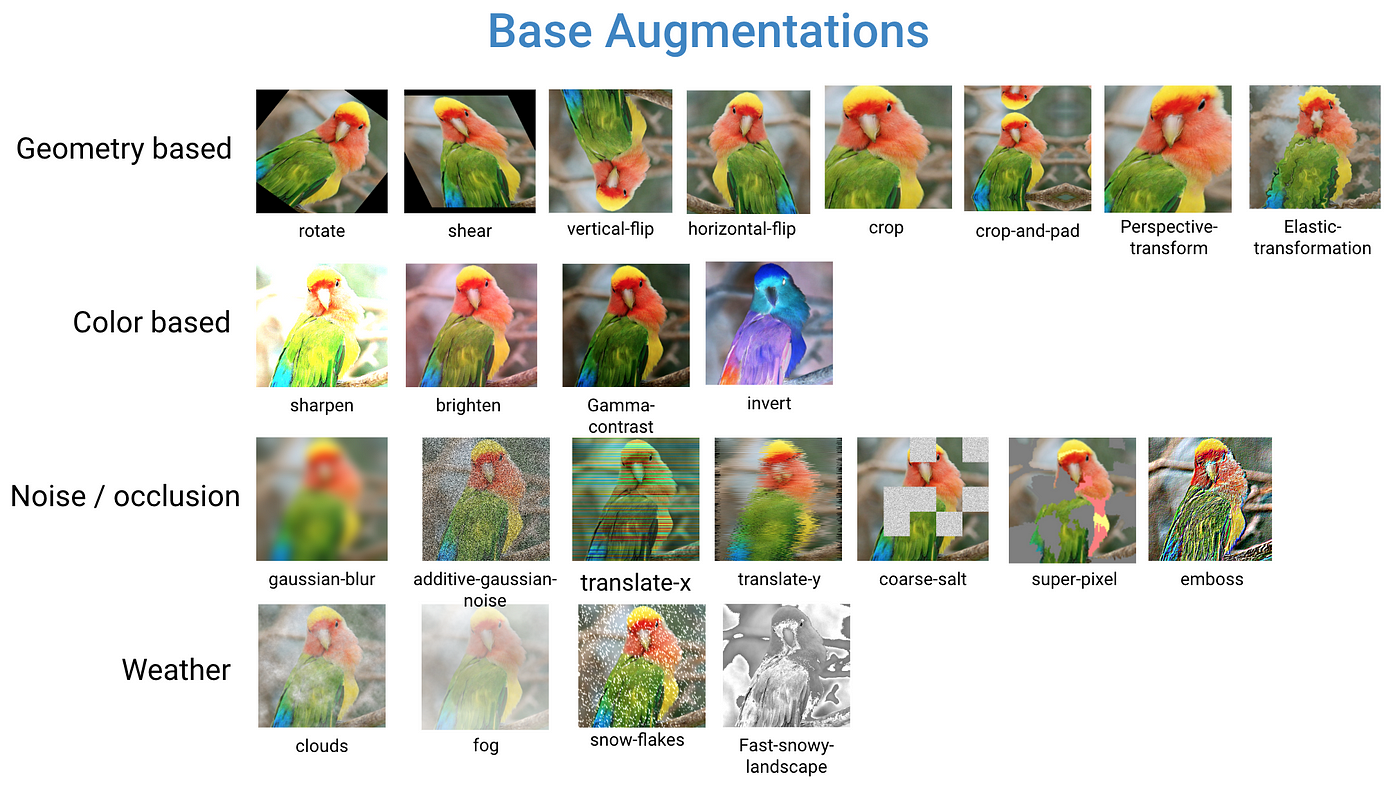


In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomAffine,
    ColorJitter,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# ทำการ Augmentation โดยการ list วิธีการที่ต้องใช้ process ภาพลงไป เช่น
# resize, RandomResizeCrop (สุ่มย่อขยายภาพและ crop), normalize อื่นๆ
train_transforms = Compose([
    Resize(feat_size),
    RandomResizedCrop(feat_size, scale=(0.8, 1.2)),
    ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

val_transforms = Compose([
    Resize(feat_size),
    ToTensor(),
    normalize,
])


def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        # เปลี่ยน รูปภาพให้อยู่ในรูป RGB
        # เก็บไว้ใน key pixel_values
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

transform รูปภาพของเราโดย input preprocess ที่เราได้กำหนดไว้ในตอนแรกลงไป

In [10]:
dataset["train"].set_transform(preprocess_train)
dataset["validation"].set_transform(preprocess_val)

In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
# สร้าง dictionary ระหว่างค่า และ id -> 1 : '01'
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
id2label[2]

'02'

## Fine-tune Our Model

- โหลดโมเดลจาก huggingface hub
- สร้าง training arguments
- จากนั้นเทรนและเซฟโมเดล

In [12]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

# เลือกโมเดลจาก Huggingface
model = AutoModelForImageClassification.from_pretrained(
    # เทรนจาก pretrain model
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([48, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([48]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# ตั้งชื่อโมเดล และกำหนด batch_size
model_name = model_checkpoint.split("/")[-1]
batch_size = 32

In [14]:
# input arguments ที่จะเป็น
args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [15]:
import torch
import numpy as np

def collate_fn(examples):
    # function ที่ใช้ในการ จัดเรียงข้อมูลของเรา ในที่นี้จะทำการเรียงรูป/label และใส่ในtensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def compute_metrics(eval_pred):
    # function ที่ใช้ในการ evaluation โมเดล
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [17]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.976400,0.627662,0.838889
2,0.432000,0.277169,0.919444
3,0.312500,0.223152,0.940972


TrainOutput(global_step=270, training_loss=1.0941412766774496, metrics={'train_runtime': 886.0021, 'train_samples_per_second': 39.007, 'train_steps_per_second': 0.305, 'total_flos': 8.601271252077773e+17, 'train_loss': 1.0941412766774496, 'epoch': 3.0})

In [18]:
trainer.save_model(f"trained/{model_name}")
# alternatively use trainer.push_to_hub instead

In [19]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.941
  eval_loss               =     0.2232
  eval_runtime            = 0:00:19.29
  eval_samples_per_second =     74.646
  eval_steps_per_second   =      2.333


## Prediction: Using Feature Extractor and Model

การใช้โมเดลที่เทรนเรียบร้อยแล้วมาทำนายภาพประกอบด้วย `AutoFeatureExtractor` และ `AutoModelForImageClassification` ทั้งนี้สามารถโหลดโมเดลจากโฟลเดอร์ที่เทรนเสร็จเรียบร้อยแล้ว หรือโหลดจาก huggingface hub ก็ได้ ในตัวอย่างนี้เราจะโหลดจากโฟล์เดอร์ที่เซฟโมเดลไป

จากนั้นสามารถอ่านภาพ `image` และแปลงให้เป็นฟีเจอร์ที่เหมาะสม ก่อนที่จะใส่เข้าไปในโมเดล โดย output ที่ได้จากโมเดลสามารถนำไปใช้ต่อได้เหมือนกับการเขียนโมเดล Pytorch ทั่วไปเลย

In [20]:
import requests
import torch
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from PIL import Image

# read trained model from a folder (please double-check if you point to the correct path)
model_name = "./trained/swin-tiny-patch4-window7-224/"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


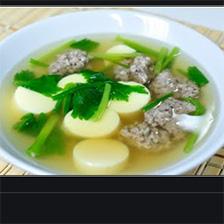

In [21]:
url = "https://github.com/GemmyTheGeek/FoodyDudy/raw/main/images/test/03/0289.jpg"
image = Image.open(requests.get(url, stream=True).raw)
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
image

In [22]:
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [23]:
pred_idx = logits.argmax(-1).item()
print("Predicted class:", id2food[model.config.id2label[pred_idx]])

Predicted class: taohoo_moosup


## Prediction: Using Pipeline API

นอกจากนั้น `transformers` ยังมี `pipeline` ที่เราเลือกชนิดของ pipeline แบบต่างๆ เช่น `image-classification` ทำให้การทำนายทำได้สะดวกยิ่งขึ้น

In [24]:
from transformers import pipeline

pipe = pipeline("image-classification", model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [25]:
pipe(image)

[{'score': 0.9978020787239075, 'label': '03'},
 {'score': 0.0016931634163483977, 'label': '04'},
 {'score': 0.0001949473371496424, 'label': '10'},
 {'score': 8.342483488377184e-05, 'label': '02'},
 {'score': 7.1116337494459e-05, 'label': '26'}]

In [26]:
[{"score": l["score"], "label": id2food[l["label"]]} for l in pipe(image)]

[{'score': 0.9978020787239075, 'label': 'taohoo_moosup'},
 {'score': 0.0016931634163483977, 'label': 'mara_yadsai'},
 {'score': 0.0001949473371496424, 'label': 'palo_egg'},
 {'score': 8.342483488377184e-05, 'label': 'liang_curry'},
 {'score': 7.1116337494459e-05, 'label': 'tom_ka_gai'}]

## Create Gradio Application for Prediction

สุดท้ายแล้วเราสามารถนำโค้ดทั้งหมดมาจัดเรียง และ deploy ด้วย Gradio application ทั้งนี้เราเพียงต้องเขียน
- ฟังก์ชั่นเพื่อ inference โดยมี `id2food` เพื่อเปลี่ยน class ที่ทำนายเป็นชื่ออาหาร
- input ซึ่งเป็นชนิดภาพ `gr.inputs.Image()`
- output เป็น label ที่ทำนายได้ `gr.outputs.Label(num_top_classes=5)`
- ประกอบร่างกันเข้ามาด้วย `gr.Interface`

In [27]:
import gradio as gr


food_list = [
    'green_curry', 'tepo_curry', 'liang_curry', 'taohoo_moosup', 'mara_yadsai',
    'masaman', 'orange_curry', 'cashew_chicken', 'omelette', 'sunny_side_up',
    'palo_egg', 'sil_egg', 'nun_banana', 'kua_gai', 'cabbage_fish_sauce',
    'river_prawn', 'shrimp_ob_woonsen', 'kanom_krok', 'mango_sticky_rice', 'kao_kamoo',
    'kao_klook_kapi', 'kaosoi', 'kao_pad', 'kao_pad_shrimp', 'chicken_rice',
    'kao_mok_gai', 'tom_ka_gai', 'tom_yum_kung', 'tod_mun', 'poh_pia',
    'pak_boong_fai_daeng', 'padthai', 'pad_krapao', 'pad_si_ew', 'pad_fakthong',
    'eggplant_stirfry', 'pad_hoi_lai', 'foithong', 'panaeng', 'yum_tua_ploo',
    'yum_woonsen', 'larb_moo', 'pumpkin_custard', 'sakoo_sai_moo', 'somtam',
    'moopoing','satay', 'hor_mok'
]
id2food = {str(i).zfill(2): f for i, f in enumerate(food_list)}


def inference(gr_input):
    """Inference function from gradio input."""
    image = Image.fromarray(gr_input.astype("uint8"), "RGB")
    predictions = pipe(image)
    predictions = {id2food[l["label"]]: l["score"] for l in predictions}
    return predictions

In [28]:
inputs = gr.inputs.Image()
outputs = gr.outputs.Label(num_top_classes=5)

interface = gr.Interface(
    fn=inference, inputs=inputs, outputs=outputs, interpretation="default",
).launch(debug="True")

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


**ผู้จัดเตรียม code ใน tutorial**: ดร. ฐิติพัทธ อัชชะกุลวิสุทธิ์